# Création du Dataset Intermédiaire
Nous allons maintenant utiliser le modele entraîné : maskrcnn_final_model.pkl sur le dossier Dataset contenant l'ensemble des dossiers par étang et créer le Dataset Intermédiaire avec l'application du masque.

# Connexion au drive et import

In [ ]:
# === 1. Importations ===
import torch
import math
import time
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import LambdaLR
from torchvision import transforms as T
import torchvision.transforms.functional as F

from PIL import Image

from torch.utils.tensorboard import SummaryWriter

# Connexion correcte à Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Spécifier le nom du répertoire
name_rep = "/231013-STSI-E01"
base_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/231013-STSI" + name_rep

Mounted at /content/drive


# 1. Instalation et import des données
On va avoir besoin dans ce modèle de pycocotools car on va se base sur ce modèle de données pour traiter notre problème

## Importation des librairies/modules et de pycocotools

In [ ]:
pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [ ]:

# Load the TensorBoard notebook extension
%load_ext tensorboard

writer = SummaryWriter('runs')


In [ ]:
pip install cython

In [ ]:
%%shell
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

# 2. Utilisation du modèle
On va récupérer le modèle entraîné (dans l'environnement d'éxécution ou stocké en local) pour réaliser des prédictions à l'aide du GPU de Google Colab

## On load le modèle

Après avoir chargé le modèle, on parcourt récursivement le dossier "Dataset"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676

Modèle chargé depuis : /content/drive/MyDrive/Colab Notebooks/Dataset/maskrcnn_final_model.pkl
Modèle prêt à l'inférence.
Image sélectionnée : /content/drive/MyDrive/Colab Notebooks/Dataset/241112-WEED/241112-WEED-E02/DSC_0057.JPG
Rotation automatique (paysage → portrait)


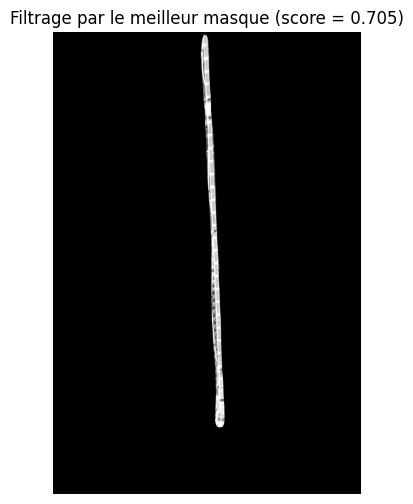

In [ ]:
import os
import random
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np
import imageio.v2 as imageio
from skimage.color import rgb2gray
from google.colab import drive, files

# === 1. Monter Google Drive ===
drive.mount('/content/drive')

# === 2. Charger le modèle ===
model_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/maskrcnn_final_model.pkl"

def get_instance_segmentation_model(num_classes):
    from torchvision.models.detection import MaskRCNN
    from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
    backbone = resnet_fpn_backbone('resnet50', pretrained=True)
    model = MaskRCNN(backbone, num_classes=num_classes)
    return model

model = get_instance_segmentation_model(2)

try:
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    print(f"Modèle chargé depuis : {model_path}")
except Exception as e:
    print("Erreur de chargement :", e)
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
    model.load_state_dict(torch.load(filename, map_location='cpu'))
    print(f"Modèle chargé depuis : {filename}")

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.eval()
print("Modèle prêt à l'inférence.")

# === 3. Parcours récursif des images ===
dataset_root = "/content/drive/MyDrive/Colab Notebooks/Dataset"
all_images = []

for root, dirs, files in os.walk(dataset_root):
    for file in files:
        if file.lower().endswith('.jpg'):
            all_images.append(os.path.join(root, file))

if not all_images:
    print("Aucune image .jpg trouvée.")
else:
    # === 4. Choix aléatoire et chargement ===
    img_path = random.choice(all_images)
    print(f"Image sélectionnée : {img_path}")

    image = Image.open(img_path).convert("RGB")
    width, height = image.size
    if width > height:
        image = image.rotate(90, expand=True)
        print("Rotation automatique (paysage → portrait)")

    # === 5. Inférence ===
    img_tensor = F.to_tensor(image).unsqueeze(0).to(device)
    with torch.no_grad():
        prediction = model(img_tensor)

       # === 6. Récupérer le meilleur masque ===
    pred = prediction[0]
    scores = pred["scores"].cpu().numpy()
    masks = pred["masks"].cpu().numpy()

    threshold = 0.5
    valid_indices = np.where(scores > threshold)[0]

    if len(valid_indices) == 0:
        print("Aucun masque détecté au-dessus du seuil.")
    else:
        best_idx = valid_indices[np.argmax(scores[valid_indices])]
        best_mask = masks[best_idx, 0]
        binary_mask = (best_mask > 0.5).astype(np.uint8)

        # Utilise l’image déjà rotée, convertie en tableau numpy
        image_np = np.array(image)
        im_gray = rgb2gray(image_np)

        # Assure compatibilité dimensions
        if binary_mask.shape != im_gray.shape:
            binary_mask = cv2.resize(binary_mask, (im_gray.shape[1], im_gray.shape[0]), interpolation=cv2.INTER_NEAREST)

        # Appliquer le masque au niveau de gris
        im_filtered = (im_gray * binary_mask) * 255
        im_filtered = im_filtered.astype(np.uint8)

        # === 7. Affichage ===
        plt.figure(figsize=(6, 6))
        plt.imshow(im_filtered, cmap='gray')
        plt.axis("off")
        plt.title(f"Filtrage par le meilleur masque (score = {scores[best_idx]:.3f})")
        plt.show()



# Application sur le Dataset

## Application pour chaque sous dossier de l'arborescence



In [ ]:
pip install tqdm #pour la barre de progression


KeyboardInterrupt: 

In [ ]:
import os
import cv2
import shutil
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
from skimage.color import rgb2gray
from tqdm import tqdm

# === Paramètres ===
source_root = "/content/drive/MyDrive/Colab Notebooks/Dataset"
target_root = "/content/drive/MyDrive/Colab Notebooks/Dataset Intermédiaire"
limit_score = 0.12

# === Initialisation modèle ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def get_transform(train=False):
    return transforms.ToTensor()

# === Collecte récursive des fichiers ===
image_paths = []
other_files = []

for root, _, files in os.walk(source_root):
    for file in files:
        full_path = os.path.join(root, file)
        ext = os.path.splitext(file)[1].lower()
        if ext == ".jpg":
            image_paths.append(full_path)
        else:
            other_files.append(full_path)

# === Traitement des images ===
for src_path in tqdm(image_paths, desc="Traitement des images"):
    rel_path = os.path.relpath(src_path, source_root)
    dst_path = os.path.join(target_root, rel_path)
    dst_dir = os.path.dirname(dst_path)
    os.makedirs(dst_dir, exist_ok=True)

    # Chargement image
    image = Image.open(src_path).convert("RGB")
    if image.width > image.height:
        image = image.rotate(90, expand=True)

    # Redimensionnement si trop grande
    max_dim = 1024
    if max(image.size) > max_dim:
        scale = max_dim / max(image.size)
        new_size = tuple(int(x * scale) for x in image.size)
        image_resized = image.resize(new_size, Image.BILINEAR)
    else:
        image_resized = image

    # Préparation
    tensor_img = get_transform()(image_resized).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(tensor_img)
    del tensor_img
    torch.cuda.empty_cache()

    scores = pred[0]["scores"].cpu().numpy()
    if len(scores) == 0 or scores[0] < limit_score:
        continue

    best_mask = pred[0]["masks"][0, 0].cpu().numpy()
    binary_mask = (best_mask > 0.5).astype(np.uint8)

    # Revenir à la taille d'origine
    im_np = np.array(image)
    im_gray = rgb2gray(im_np)

    if binary_mask.shape != im_gray.shape:
        binary_mask = cv2.resize(binary_mask, (im_gray.shape[1], im_gray.shape[0]), interpolation=cv2.INTER_NEAREST)

    im_masked = (im_gray * binary_mask) * 255
    im_masked = im_masked.astype(np.uint8)

    # Sauvegarde image traitée
    cv2.imwrite(dst_path, im_masked)

# == Copie des autres fichiers sans traitement ==
for src_file in other_files:
    rel_path = os.path.relpath(src_file, source_root)
    dst_path = os.path.join(target_root, rel_path)
    dst_dir = os.path.dirname(dst_path)
    os.makedirs(dst_dir, exist_ok=True)
    shutil.copy2(src_file, dst_path)
